In [ ]:
pip install ultralytics

In [ ]:
pip install opencv-python opencv-python-headless

In [ ]:
!pip install torch torchvision opencv-python

In [ ]:
import torch
from model import enhance_net_nopool  # Import the Zero-DCE model

# Load the model and specify map_location='cpu'
model = enhance_net_nopool()
model.load_state_dict(torch.load('/content/Epoch99.pth', map_location=torch.device('cpu')))  # Use the correct path
model.eval()  # Set model to evaluation mode


enhance_net_nopool(
  (relu): ReLU(inplace=True)
  (e_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv7): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
)

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from model import enhance_net_nopool  # Import your model

# Preprocessing transformations without normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # No normalization for now
])

# Load the model
model = enhance_net_nopool()
model.load_state_dict(torch.load('/content/Epoch99.pth', map_location=torch.device('cpu'), weights_only=True))
model.eval()  # Set model to evaluation mode

def enhance_image(image_path, output_image_path):
    # Read image using OpenCV (ensure it's RGB)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Apply the necessary transformations
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension (1, C, H, W)

    # Set model to evaluation mode and perform inference
    with torch.no_grad():
        output = model(image_tensor)

    # If the model outputs a tuple, get the first element (enhanced image)
    enhanced_image = output[0] if isinstance(output, tuple) else output

    # Convert the tensor back to a numpy image (H, W, C)
    enhanced_image = enhanced_image.squeeze().numpy()  # Remove batch dimension
    enhanced_image = np.transpose(enhanced_image, (1, 2, 0))  # Convert to HWC format
    enhanced_image = np.clip(enhanced_image * 255, 0, 255).astype(np.uint8)  # Rescale to [0, 255]

    # Save the enhanced image
    cv2.imwrite(output_image_path, cv2.cvtColor(enhanced_image, cv2.COLOR_RGB2BGR))  # Convert RGB back to BGR for saving

    return enhanced_image

# Example usage
image_path = '/content/testnight.jpg'  # Replace with your image path
output_image_path = "enhanced_ZeroDCE_image.jpg"  # Path to save the enhanced image
enhanced_img = enhance_image(image_path, output_image_path)

# Display the enhanced image
plt.imshow(enhanced_img)
plt.axis('off')
plt.title("Enhanced Image")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define the architecture of the model
def build_ann_model(input_dim):
    model = models.Sequential()

    # Input Layer + First Hidden Layer (Dense + Dropout)
    model.add(layers.Dense(512, activation='relu', input_dim=input_dim))
    model.add(layers.Dropout(0.5))  # Regularization

    # Second Hidden Layer
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Third Hidden Layer
    model.add(layers.Dense(128, activation='relu'))

    # Fourth Hidden Layer
    model.add(layers.Dense(64, activation='relu'))

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification (collision risk: high/low)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Example of input data, assuming extracted features from the object detection step
# You can replace this with your actual feature data
input_data = np.random.rand(1000, 10)  # 1000 samples, 10 features (can be bounding boxes, object type, etc.)
output_data = np.random.randint(2, size=1000)  # Binary labels (1 = high risk, 0 = low risk)

# Scaling the data to standardize features
scaler = StandardScaler()
input_data_scaled = scaler.fit_transform(input_data)

# Build and train the model
model = build_ann_model(input_dim=input_data_scaled.shape[1])

# Train the model
model.fit(input_data_scaled, output_data, epochs=50, batch_size=32, validation_split=0.2)

# Save the model for later use
model.save('risk_prediction_ann_model.h5')

# You can later use the model for prediction
predictions = model.predict(input_data_scaled)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4956 - loss: 0.6995 - val_accuracy: 0.5200 - val_loss: 0.6968
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5404 - loss: 0.6908 - val_accuracy: 0.4650 - val_loss: 0.7023
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5656 - loss: 0.6870 - val_accuracy: 0.5200 - val_loss: 0.7027
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5507 - loss: 0.6881 - val_accuracy: 0.5200 - val_loss: 0.7037
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5217 - loss: 0.6906 - val_accuracy: 0.5000 - val_loss: 0.7052
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5609 - loss: 0.6785 - val_accuracy: 0.4550 - val_loss: 0.7141
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5465 - loss: 0.6841 - val_accuracy: 0.4750 - val_loss: 0.7186
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5379 - loss: 0.6773 - val_accuracy: 0.5000 - val


0: 352x640 5 cars, 348.4ms
Speed: 3.3ms preprocess, 348.4ms inference, 5.6ms postprocess per image at shape (1, 3, 352, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


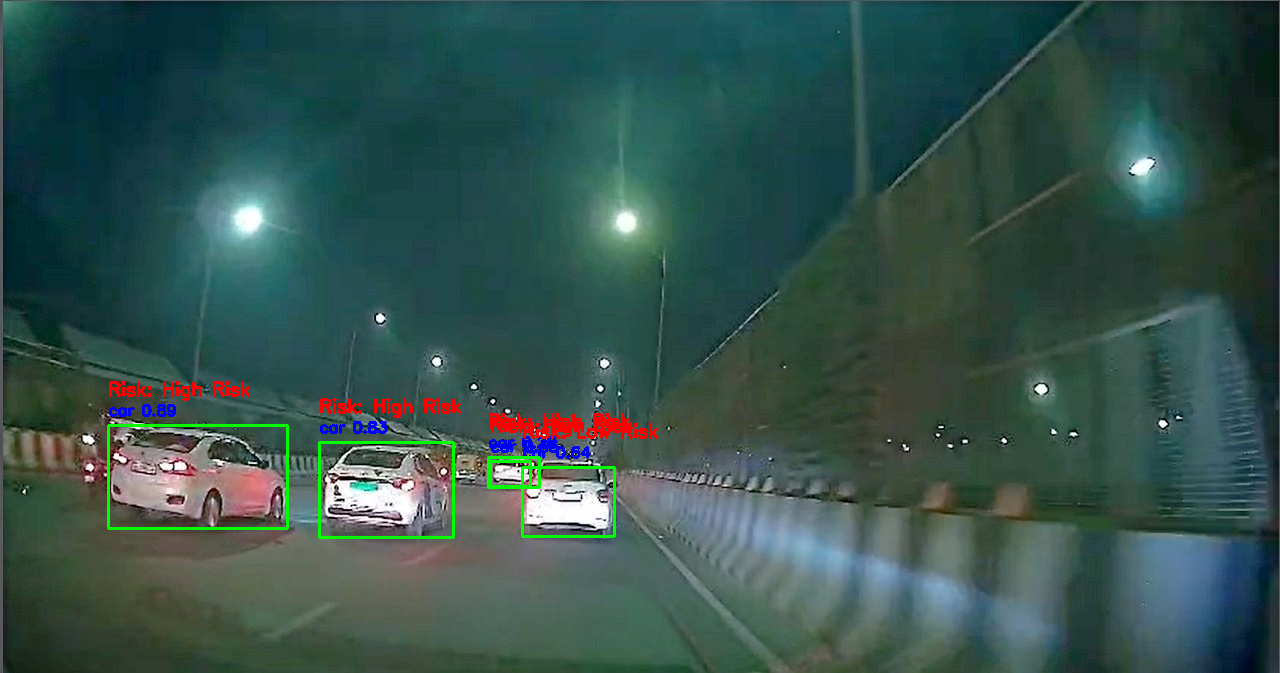

Output image saved as YOLO5_with_risk_prediction.jpg


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from ultralytics import YOLO  # Correct import

# Load the trained ANN model (change path as needed)
ann_model = load_model('risk_prediction_ann_model.h5')

def detect_objects_and_predict_risk(image_path, output_path):
    # Load the YOLO model (pretrained on COCO dataset)
    model = YOLO("yolov5su.pt")  # Replace with yolov8n.pt or other models if needed

    # Read the input image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not load image.")
        return

    # Perform Object Detection
    results = model.predict(img)

    # List to hold features for ANN input
    features = []

    # Iterate through detected objects
    for result in results:
        boxes = result.boxes  # Access detected bounding boxes
        for box in boxes:
            # Extract bounding box coordinates and confidence score
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            confidence = float(box.conf[0])  # Confidence score
            cls = int(box.cls[0])  # Class index
            label = model.names[cls]  # Class name

            # Calculate features (e.g., bounding box area, confidence, distance, etc.)
            area = (x2 - x1) * (y2 - y1)  # Area of the bounding box
            distance = np.random.uniform(5, 100)  # Replace with actual logic if available

            # Example additional features (you can modify this part)
            speed = np.random.uniform(0, 10)  # Hypothetical feature for object speed
            relative_position = np.random.uniform(-5, 5)  # Relative position (distance to vehicle)

            # Add more features to match the expected input shape (10 features in total)
            features.append([area, confidence, distance, speed, relative_position, 0, 0, 0, 0, 0])  # Adjust accordingly

            # Draw bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Put label and confidence above the box
            label_text = f"{label} {confidence:.2f}"
            cv2.putText(
                img,
                label_text,
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 0, 0),
                2
            )

    # Convert features list to numpy array and scale it
    features_scaled = np.array(features)  # Shape (num_objects, num_features)

    # Assuming scaling was done during model training, apply the same scaling
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_scaled)

    # Use the ANN model to predict risk
    predictions = ann_model.predict(features_scaled)

    # Recommendations based on predictions
    for i, prediction in enumerate(predictions):
        risk = 'High Risk' if prediction >= 0.5 else 'Low Risk'
        label_text = f"Risk: {risk}"

        # Update bounding box label with risk prediction
        x1, y1, x2, y2 = map(int, boxes[i].xyxy[0])
        cv2.putText(
            img,
            label_text,
            (x1, y1 - 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 0, 255),  # Red color for risk label
            2
        )

    # Save the output image
    cv2.imwrite(output_path, img)

    # Display the result
    cv2_imshow(img)
    print(f"Output image saved as {output_path}")

# Example usage
input_image_path = "/content/enhanced_ZeroDCE_image.jpg"  # Replace with your input image path
output_image_path = "YOLO5_with_risk_prediction.jpg"  # Replace with desired output path
detect_objects_and_predict_risk(input_image_path, output_image_path)



0: 352x640 5 cars, 347.5ms
Speed: 3.5ms preprocess, 347.5ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


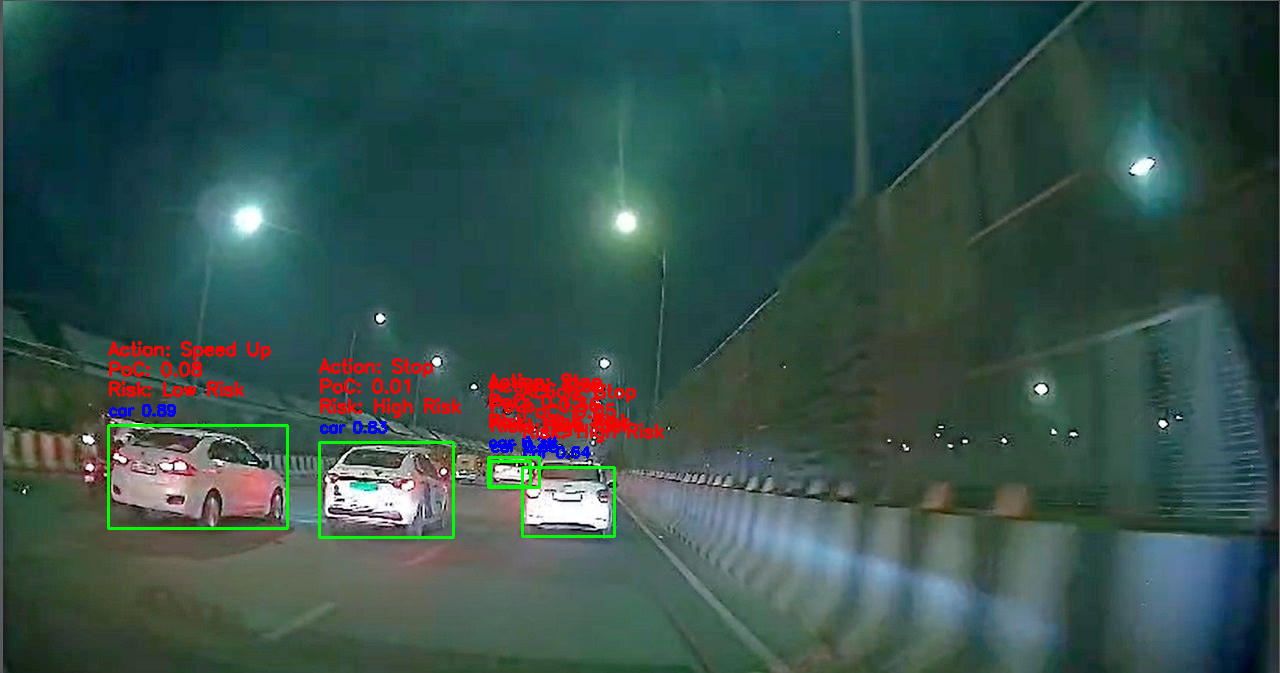

Output image saved as YOLO5_with_risk_prediction_and_poc.jpg


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from ultralytics import YOLO  # Correct import

# Load the trained ANN model (change path as needed)
ann_model = load_model('risk_prediction_ann_model.h5')

# Function to calculate the probability of collision (PoC)
def calculate_poc(distance, speed, risk):
    # For simplicity, assume PoC increases with speed and decreases with distance
    if risk == 'High Risk':
        poc = min(1.0, (1 / distance) * speed * 0.1)  # Higher probability for high-risk
    else:
        poc = min(0.5, (1 / distance) * speed * 0.05)  # Lower probability for low-risk
    return poc

def detect_objects_and_predict_risk(image_path, output_path):
    # Load the YOLO model (pretrained on COCO dataset)
    model = YOLO("yolov5su.pt")  # Replace with yolov8n.pt or other models if needed

    # Read the input image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not load image.")
        return

    # Perform Object Detection
    results = model.predict(img)

    # List to hold features for ANN input
    features = []

    # Iterate through detected objects
    for result in results:
        boxes = result.boxes  # Access detected bounding boxes
        for box in boxes:
            # Extract bounding box coordinates and confidence score
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            confidence = float(box.conf[0])  # Confidence score
            cls = int(box.cls[0])  # Class index
            label = model.names[cls]  # Class name

            # Calculate features (e.g., bounding box area, confidence, distance, etc.)
            area = (x2 - x1) * (y2 - y1)  # Area of the bounding box
            distance = np.random.uniform(5, 100)  # Replace with actual logic if available
            speed = np.random.uniform(0, 10)  # Hypothetical feature for object speed
            relative_position = np.random.uniform(-5, 5)  # Relative position (distance to vehicle)

            # Add features to match the expected input shape (10 features in total)
            features.append([area, confidence, distance, speed, relative_position, 0, 0, 0, 0, 0])  # Adjust accordingly

            # Draw bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Put label and confidence above the box
            label_text = f"{label} {confidence:.2f}"
            cv2.putText(
                img,
                label_text,
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 0, 0),
                2
            )

    # Convert features list to numpy array and scale it
    features_scaled = np.array(features)  # Shape (num_objects, num_features)

    # Assuming scaling was done during model training, apply the same scaling
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_scaled)

    # Use the ANN model to predict risk
    predictions = ann_model.predict(features_scaled)

    # Recommendations and PoC based on predictions
    for i, prediction in enumerate(predictions):
        risk = 'High Risk' if prediction >= 0.5 else 'Low Risk'
        label_text = f"Risk: {risk}"

        # Calculate PoC based on distance and speed
        poc = calculate_poc(features_scaled[i][2], features_scaled[i][3], risk)  # Using distance and speed for PoC
        poc_text = f"PoC: {poc:.2f}"

        # Provide recommendations
        if risk == 'High Risk':
            recommendation = "Stop"
        else:
            recommendation = "Turn" if features_scaled[i][4] > 0 else "Speed Up"

        # Update bounding box label with risk, PoC, and recommendation
        x1, y1, x2, y2 = map(int, boxes[i].xyxy[0])
        cv2.putText(
            img,
            label_text,
            (x1, y1 - 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 0, 255),  # Red color for risk label
            2
        )
        cv2.putText(
            img,
            poc_text,
            (x1, y1 - 50),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 0, 255),  # Red color for PoC label
            2
        )
        cv2.putText(
            img,
            f"Action: {recommendation}",
            (x1, y1 - 70),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 0, 255),  # Red color for action label
            2
        )

    # Save the output image
    cv2.imwrite(output_path, img)

    # Display the result
    cv2_imshow(img)
    print(f"Output image saved as {output_path}")

# Example usage
input_image_path = "/content/enhanced_ZeroDCE_image.jpg"  # Replace with your input image path
output_image_path = "YOLO5_with_risk_prediction_and_poc.jpg"  # Replace with desired output path
detect_objects_and_predict_risk(input_image_path, output_image_path)
